# Observer

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

plt.style.use("seaborn-v0_8")

k_rw = 0.1
k_wo = 0.02
k_in = 0.5
T_out = 33

A = np.array([[-k_rw, k_rw],
              [k_rw, -(k_rw + k_wo)]])
B = np.array([[k_in, 0],
              [0, k_wo]])
C = np.array([[1, 0]])
D = np.array([[0, 0]])

SS1 = signal.StateSpace(A, B, C, D)


In [36]:
t = np.linspace(0, 300, 301)
u = np.array([np.zeros_like(t),
              np.ones_like(t) * T_out]).T

t, y1, x1 = signal.lsim(SS1, u, t, X0=[30, 30])
print(f"Output y's shape: {y1.shape}")

Output y's shape: (301,)


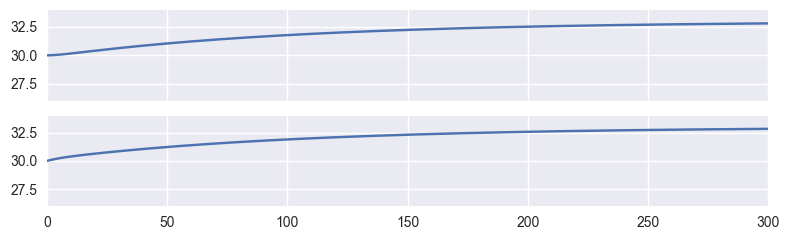

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 2.5))
axs[0].plot(t, x1[:, 0], label="x1")
axs[1].plot(t, x1[:, 1], label="x2")
for ax in axs:
    ax.set_xlim(0, 300)
    ax.set_ylim(26, 34)

plt.tight_layout()
plt.show()

In [38]:
# Observability
O = np.vstack([C, np.dot(C, A)])
is_observable = np.linalg.matrix_rank(O) == A.shape[0]
print(f"Is observable: {is_observable}")

Is observable: True


In [39]:
# Get the observer gain
np.linalg.eigvals(A)
P = np.array([-0.0095, -0.21])

L = signal.place_poles(A.T, C.T, P).gain_matrix.T
print(f"Observer gain:")
print(L)
# Observer gain:
# [[-0.0005 ]
#  [ 0.00055]]

eigs = np.linalg.eigvals(A - L @ C)
print(f"Observer poles:")
print(eigs)

Observer gain:
[[-0.0005 ]
 [ 0.00055]]
Observer poles:
[-0.0095 -0.21  ]


In [40]:
# Observer dynamics
A_obs = A - L @ C
B_obs = np.hstack([B, L])
C_obs = np.eye(2)
D_obs = np.zeros((2, 3))

SS_obs = signal.StateSpace(A_obs, B_obs, C_obs, D_obs)

In [41]:
y_ = np.reshape(y1, (len(y1), 1))  # Need to convert (n,) to (n, 1)
u2 = np.hstack([u, y_])
t, x_hat, _ = signal.lsim(SS_obs, u2, t)

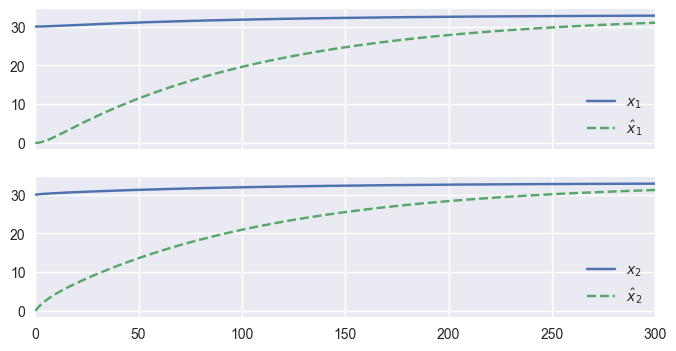

In [34]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
axs[0].plot(t, x1[:, 0], label=r"$x_1$")
axs[0].plot(t, x_hat[:, 0], "--", label=r"$\hat x_1$")
axs[1].plot(t, x1[:, 1], label=r"$x_2$")
axs[1].plot(t, x_hat[:, 1], "--", label=r"$\hat x_2$")
for ax in axs:
    ax.set_xlim(0, 300)
    ax.legend()
plt.show()

# Output Control

In [29]:
# Copying the feedback gain matrix and feedforward gain from the previous notebook
K = np.array([[0.22, 0.2],
              [5.00, -5.525]])
kf = 0.44

In [30]:
# The dynamics of the system with the observer. The observer should track the actual system state and guide 
# the state to the desired reference values.
T_ref = 27
t = np.linspace(0, 300, 301)

def func(t, z, u):
    """The dynamics of the system and the observer. The observer should track the actual system state 
    using the system output (y), input (u), A_hat, B_hat, C, and the observer gain (L). 
    """    
    x, x_hat = np.split(z, 2)
    
    A_hat = A - B @ K
    B_hat = kf * B
    dxdt = A_hat @ x + B_hat @ u(t)  # Process dynamics
    
    y = C @ x  # Output from the process
    dx_hat_dt = A_hat @ x_hat + B_hat @ u(t) + L @ (y - C @ x_hat)  # Observer dynamics
    return np.concatenate([dxdt, dx_hat_dt])
    
def input_func(t):
    return np.array([T_ref, T_out])

from scipy.integrate import solve_ivp
sol = solve_ivp(func, [0, 300], np.hstack([[30, 30], [0, 0]]), t_eval=t, args=(input_func,))

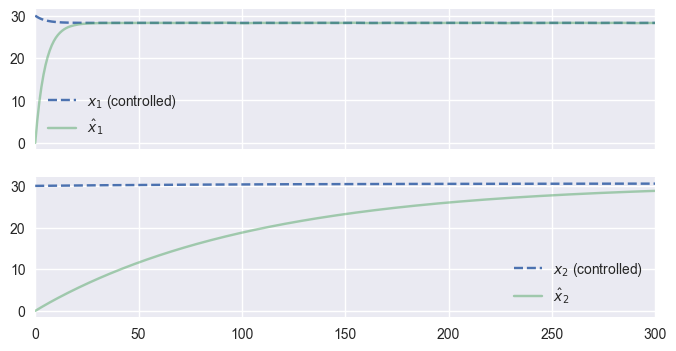

In [31]:
x_true, x_hat = np.split(sol.y, 2)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
axs[0].plot(t, x_true[0], "--", label=r"$x_1$ (controlled)")
axs[0].plot(t, x_hat[0], label=r"$\hat x_1$", alpha=0.5)
axs[1].plot(t, x_true[1], "--", label=r"$x_2$ (controlled)")
axs[1].plot(t, x_hat[1], label=r"$\hat x_2$", alpha=0.5)
for ax in axs:
    ax.set_xlim(0, 300)
    ax.legend()
plt.show()